# Retail Customer Churn & A/B Test Analysis

This project analyzes customer purchase behavior to identify churn drivers and evaluates an A/B test designed to improve early retention.


## Data Loading

In [2]:
import pandas as pd

df_1 = pd.read_excel('/content/kaggle_retaildata.xlsx', sheet_name='Year 2009-2010')
df_2 = pd.read_excel('/content/kaggle_retaildata.xlsx', sheet_name='Year 2010-2011')

# Combine into one dataframe
df = pd.concat([df_1, df_2], ignore_index=True)

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
df.columns = df.columns.str.strip()
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

## Data Preparation & Cleaning


In [4]:

df=df.dropna(subset=['Customer ID'])
df = df[~df['Invoice'].astype(str).str.startswith('C')]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df=df[(df['Quantity']>0) & (df['Price']>0)]


In [5]:
df.shape

(805549, 8)

In [6]:
df['Revenue'] = df['Quantity'] * df['Price']

In [7]:
df = df.sort_values(by=['Customer ID', 'InvoiceDate'])

## Churn Definition

A customer is considered churned if they do not make a repeat purchase within a defined time window.


In [8]:

last_purchase = (
    df.groupby('Customer ID')['InvoiceDate']
      .max()
      .reset_index()
      .rename(columns={'InvoiceDate': 'LastPurchaseDate'})
)


In [9]:
analysis_date = df['InvoiceDate'].max()
analysis_date

Timestamp('2011-12-09 12:50:00')

In [10]:
last_purchase['DaysSinceLastPurchase'] = (
    analysis_date - last_purchase['LastPurchaseDate']
).dt.days

In [11]:
last_purchase['Churned'] = last_purchase['DaysSinceLastPurchase'] > 90

In [12]:
last_purchase['Churned'].value_counts(normalize=True) * 100

,proportion
Churned,
True,50.782579
False,49.217421


## Exploratory Data Analysis

We analyze churn distribution and behavioral differences between churned and retained customers.


In [13]:
customer_features = (
    df.groupby('Customer ID')
      .agg(
          total_orders=('Invoice', 'nunique'),
          total_revenue=('Revenue', 'sum'),
          avg_order_value=('Revenue', 'mean'),
          total_items=('Quantity', 'sum'),
          first_purchase=('InvoiceDate', 'min'),
          last_purchase=('InvoiceDate', 'max')
      )
      .reset_index()
)


In [14]:
customer_features = customer_features.merge(
    last_purchase[['Customer ID', 'Churned']],
    on='Customer ID',
    how='left'
)

customer_features.head()


,Customer ID,total_orders,total_revenue,avg_order_value,total_items,first_purchase,last_purchase,Churned
0,12346.0,12,77556.46,2281.072353,74285,2009-12-14 08:34:00,2011-01-18 10:01:00,True
1,12347.0,8,5633.32,22.266087,3286,2010-10-31 14:20:00,2011-12-07 15:52:00,False
2,12348.0,5,2019.40,39.596078,2714,2010-09-27 14:59:00,2011-09-25 13:13:00,False
3,12349.0,4,4428.69,25.306800,1624,2010-04-29 13:20:00,2011-11-21 09:51:00,False
4,12350.0,1,334.40,19.670588,197,2011-02-02 16:01:00,2011-02-02 16:01:00,True


In [15]:
customer_features.groupby('Churned').mean(numeric_only=True)

,Customer ID,total_orders,total_revenue,avg_order_value,total_items
Churned,,,,,
False,15295.467681,9.631179,4936.467964,49.631740,2901.980643
True,15334.547739,3.050586,1159.875162,47.009298,774.116248


In [16]:
df['PrevInvoiceDate'] = df.groupby('Customer ID')['InvoiceDate'].shift(1)
df['DaysBetweenOrders'] = (df['InvoiceDate'] - df['PrevInvoiceDate']).dt.days

In [17]:
gap_analysis = (
    df.merge(last_purchase[['Customer ID', 'Churned']], on='Customer ID')
      .groupby('Churned')['DaysBetweenOrders']
      .mean()
)

gap_analysis


,DaysBetweenOrders
Churned,
False,1.843374
True,2.516101


In [20]:
#age

df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

cohort = (
    df.groupby('Customer ID')['InvoiceMonth']
      .min()
      .reset_index()
      .rename(columns={'InvoiceMonth': 'CohortMonth'})
)

df = df.merge(cohort, on='Customer ID')


In [21]:
def get_month_diff(later, earlier):
    return (later.year - earlier.year) * 12 + (later.month - earlier.month)

df['CohortIndex'] = df.apply(
    lambda row: get_month_diff(row['InvoiceMonth'], row['CohortMonth']),
    axis=1
)


In [22]:
cohort_counts = (
    df.groupby(['CohortMonth', 'CohortIndex'])['Customer ID']
      .nunique()
      .reset_index()
)

cohort_pivot = cohort_counts.pivot(
    index='CohortMonth',
    columns='CohortIndex',
    values='Customer ID'
)


In [23]:
cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0)

retention.head()


CohortIndex,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2009-12,1.0,0.352880,0.334031,0.425131,0.380105,0.359162,0.376963,0.342408,0.336126,0.362304,...,0.302618,0.262827,0.302618,0.282723,0.259686,0.255497,0.315183,0.304712,0.407330,0.196859
2010-01,1.0,0.206266,0.310705,0.305483,0.263708,0.300261,0.258486,0.229765,0.279373,0.318538,...,0.151436,0.234987,0.198433,0.185379,0.195822,0.242820,0.193211,0.245431,0.057441,NaN
2010-02,1.0,0.237968,0.224599,0.291444,0.245989,0.200535,0.192513,0.286096,0.254011,0.275401,...,0.200535,0.160428,0.163102,0.144385,0.229947,0.229947,0.163102,0.058824,NaN,NaN
2010-03,1.0,0.189616,0.230248,0.241535,0.232506,0.203160,0.246050,0.302483,0.275395,0.108352,...,0.169300,0.173815,0.155756,0.176072,0.200903,0.212190,0.079007,NaN,NaN,NaN
2010-04,1.0,0.193878,0.193878,0.163265,0.183673,0.224490,0.275510,0.261905,0.105442,0.108844,...,0.156463,0.139456,0.149660,0.180272,0.224490,0.057823,NaN,NaN,NaN,NaN


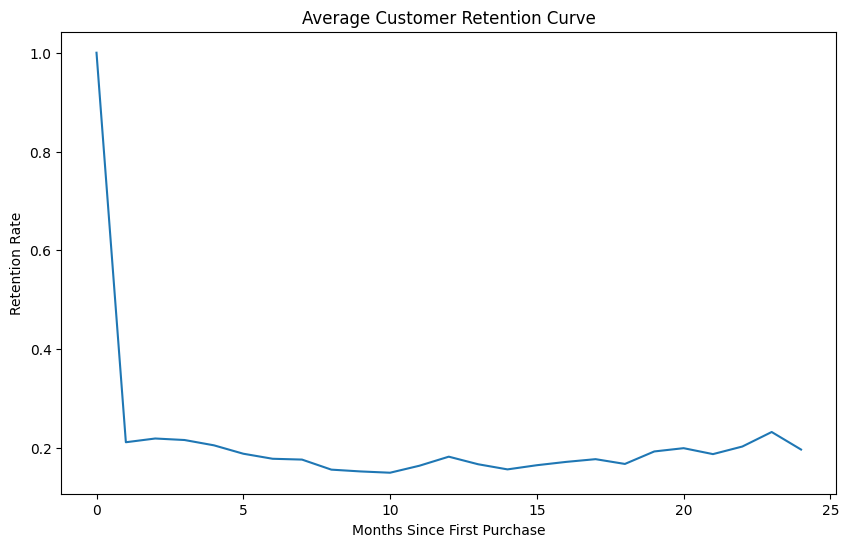

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(retention.columns, retention.mean())
plt.xlabel('Months Since First Purchase')
plt.ylabel('Retention Rate')
plt.title('Average Customer Retention Curve')
plt.show()


## A/B Test Results & Interpretation

The observed difference between control and treatment groups was not statistically significant (p > 0.05).  
This suggests the tested intervention did not meaningfully reduce churn and would require iteration before rollout.


In [25]:

first_purchase = (
    df.groupby('Customer ID')['InvoiceDate']
      .min()
      .reset_index()
      .rename(columns={'InvoiceDate': 'FirstPurchaseDate'})
)

df_exp = df.merge(first_purchase, on='Customer ID')

df_first = df_exp[df_exp['InvoiceDate'] == df_exp['FirstPurchaseDate']]



In [27]:
#Control Treatment

import numpy as np

np.random.seed(42)
df_first['experiment_group'] = np.random.choice(
    ['control', 'treatment'],
    size=len(df_first)
)


df_exp['DaysFromFirst'] = (
    df_exp['InvoiceDate'] - df_exp['FirstPurchaseDate']
).dt.days


second_purchase = (
    df_exp[
        (df_exp['DaysFromFirst'] > 0) &
        (df_exp['DaysFromFirst'] <= 30)
    ]
    .groupby('Customer ID')
    .size()
    .reset_index(name='SecondPurchase')
)

df_first = df_first.merge(
    second_purchase[['Customer ID']],
    on='Customer ID',
    how='left'
)

df_first['Converted'] = df_first['Customer ID'].isin(
    second_purchase['Customer ID']
)

conversion_rates = (
    df_first.groupby('experiment_group')['Converted']
    .mean()
    * 100
)

conversion_rates

from statsmodels.stats.proportion import proportions_ztest

control = df_first[df_first['experiment_group'] == 'control']['Converted']
treatment = df_first[df_first['experiment_group'] == 'treatment']['Converted']

counts = [treatment.sum(), control.sum()]
nobs = [len(treatment), len(control)]

z_stat, p_value = proportions_ztest(counts, nobs)
z_stat, p_value




/tmp/ipython-input-1340901287.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first['experiment_group'] = np.random.choice(


(np.float64(-0.4946420197660503), np.float64(0.6208528355413994))

## A/B Test Results & Interpretation

The experiment results were not statistically significant (p-value > 0.05).
This indicates that the tested intervention did not have a measurable impact on early retention and would require further iteration before rollout.
